In [148]:
from mne.io import read_raw_edf
from scipy.signal import resample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

Extracting EDF parameters from /home/andrew/sleep/sleep_ml/data/CohortD/recordings/D1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Index(['1', 'n', 'r', 'w'], dtype='object')


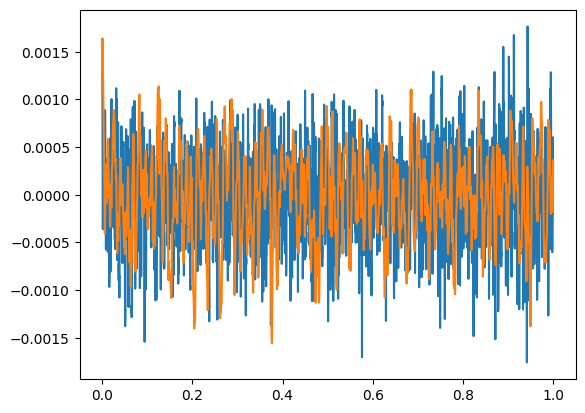

In [178]:
cohort = f'D'
subject = f'1'
raw = read_raw_edf(f'./data/Cohort{cohort}/recordings/{cohort}{subject}.edf')
eeg = raw.get_data('EEG1').squeeze()
plt.plot(np.linspace(0,1,512*10),eeg[:512*10])
eeg = resample(eeg,86400*500)
plt.plot(np.linspace(0,1,500*10),eeg[:500*10])
X = torch.from_numpy(eeg.reshape(-1,5000)).float()
df = pd.read_csv(f'data/Cohort{cohort}/scorings/{cohort}{subject}.csv',header=None)
cat = pd.Categorical(df[1])
cats = cat.categories
print(cats)
labels = np.array([[a]*2000 for a in list(cat.codes)]).flatten()
y = torch.from_numpy(labels.reshape(-1,5000)).mode(dim=1).values
y[torch.where(y == 0)[0]] = 5
y[torch.where(y == 1)[0]] = 3
y[torch.where(y == 2)[0]] = 4
y[torch.where(y == 3)[0]] = 1
y[torch.where(y == 4)[0]] = 0
y[torch.where(y == 5)[0]] = 2
y = torch.nn.functional.one_hot(y.long()).float()
# ['1', '2', '3', 'n', 'r', 'w']

In [172]:
model = Gandalf()
model.load_state_dict(torch.load(f=f'../gandalfs/gandalf_0/best_model.pt',map_location='cpu'))
model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()

In [173]:
dataloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
loss,metrics,y_true,y_pred,logits = evaluate(dataloader,model,criterion,DEVICE)

100%|██████████| 270/270 [00:10<00:00, 25.78it/s]
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


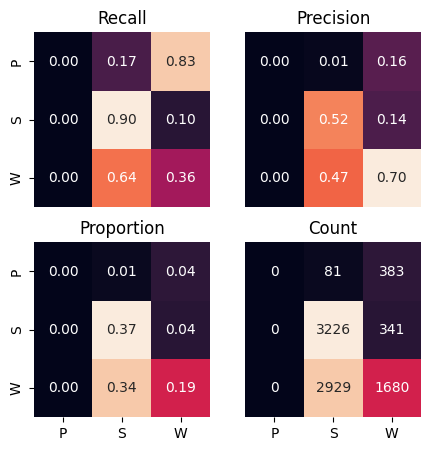

In [174]:
cm_grid(y_true,y_pred)